In [20]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Allow notebook to import from the 'src' directory
sys.path.append(os.path.abspath('../src'))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
import joblib

In [10]:
from model_train import train_and_evaluate 

In [ ]:
# --- DATASET 1: E-COMMERCE (Fraud_Data) ---
ecommerce_df = pd.read_csv('../data/processed/processed_fraud_data.csv')

In [5]:
# Select engineered features + original numeric ones
e_features = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 
              'day_of_week', 'device_id_count', 'ip_address_count']
X_e = ecommerce_df[e_features]
y_e = ecommerce_df['class']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_e, y_e, test_size=0.2, random_state=42, stratify=y_e
)

In [6]:
# --- DATASET 2: BANK CREDIT (creditcard.csv) ---
credit_df = pd.read_csv('../data/raw/creditcard.csv')

In [8]:
# Pre-processing: Scale 'Time' and 'Amount' (V1-V28 are already scaled/PCA'd)
scaler = StandardScaler()
credit_df['Time'] = scaler.fit_transform(credit_df[['Time']])
credit_df['Amount'] = scaler.fit_transform(credit_df[['Amount']])

X_c = credit_df.drop('Class', axis=1)
y_c = credit_df['Class']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42, stratify=y_c
)

In [11]:
# train for both datasets fruad and credit
train_and_evaluate(X_train_e, X_test_e, y_train_e, y_test_e, "E-Commerce Fraud")
train_and_evaluate(X_train_c, X_test_c, y_train_c, y_test_c, "Bank Credit Fraud")


==== Results for E-Commerce Fraud ====
Logistic Regression: F1-Score = 0.6646 | AUPRC = 0.6232
Random Forest: F1-Score = 0.6106 | AUPRC = 0.7024

==== Results for Bank Credit Fraud ====
Logistic Regression: F1-Score = 0.1141 | AUPRC = 0.7189
Random Forest: F1-Score = 0.7921 | AUPRC = 0.7862


In [15]:
# --- 1. Train E-commerce Model ---
rf_model_e = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)
rf_model_e.fit(X_train_e, y_train_e)

# --- 2. Train Bank Credit Model ---
rf_model_c = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)
rf_model_c.fit(X_train_c, y_train_c)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


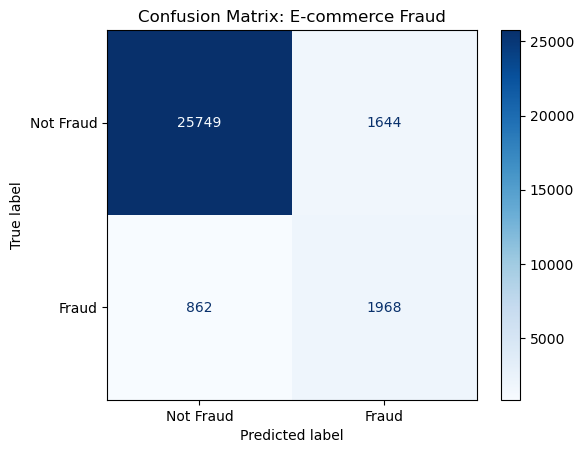

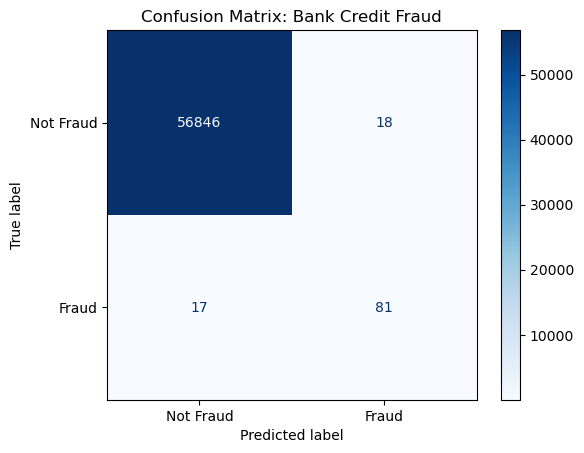

In [17]:
def plot_fraud_confusion_matrix(model, X_test, y_test, title):
    # This automatically predicts and plots the matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        model, 
        X_test, 
        y_test, 
        display_labels=['Not Fraud', 'Fraud'],
        cmap='Blues',
        values_format='d' # 'd' for integer format
    )
    disp.ax_.set_title(title)
    plt.show()

# Run for E-commerce
plot_fraud_confusion_matrix(rf_model_e, X_test_e, y_test_e, "Confusion Matrix: E-commerce Fraud")

# Run for Bank Credit
plot_fraud_confusion_matrix(rf_model_c, X_test_c, y_test_c, "Confusion Matrix: Bank Credit Fraud")

In [19]:
def run_cross_validation(model, X, y, dataset_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # We use 'f1' and 'average_precision' (AUPRC)
    scoring = ['f1', 'average_precision']
    
    cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    
    print(f"\n--- {dataset_name} Cross-Validation (k=5) ---")
    print(f"Mean F1: {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")
    print(f"Mean AUPRC: {cv_results['test_average_precision'].mean():.4f} (+/- {cv_results['test_average_precision'].std():.4f})")

# Run for E-commerce (Random Forest)
run_cross_validation(rf_model_e, X_e, y_e, "E-Commerce Fraud")

# Run for Bank Credit (Random Forest)
run_cross_validation(rf_model_c, X_c, y_c, "Bank Credit Fraud")


--- E-Commerce Fraud Cross-Validation (k=5) ---
Mean F1: 0.6189 (+/- 0.0052)
Mean AUPRC: 0.7143 (+/- 0.0067)

--- Bank Credit Fraud Cross-Validation (k=5) ---
Mean F1: 0.8359 (+/- 0.0282)
Mean AUPRC: 0.8228 (+/- 0.0261)


In [21]:
# Create the directory if it doesn't exist
model_path = '../models/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

# 1. Save the E-commerce Fraud Model
joblib.dump(rf_model_e, os.path.join(model_path, 'ecommerce_fraud_model.pkl'))

# 2. Save the Bank Credit Fraud Model
joblib.dump(rf_model_c, os.path.join(model_path, 'credit_fraud_model.pkl'))

print(f"Successfully saved both models to {model_path}")

Successfully saved both models to ../models/
